In [28]:
# supress warnings
import warnings 
warnings.filterwarnings('ignore')

# data manipulation
import pandas as pd
import re # regex
import string

# machine learning
from sklearn.feature_extraction.text import TfidfVectorizer

# data visualisation
import matplotlib.pyplot as plt

# NLP
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords') # comment out if already downloaded
stop_words = set(stopwords.words('english'))
nltk.download('punkt')     # comment out if already downloaded
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

# Display all columns
pd.set_option('display.max_columns', None)

# unsupervised learning modules

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
!pip install gensim
from gensim import corpora
from gensim.models import LsiModel
from gensim.models.ldamodel import LdaModel
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel

from pprint import pprint

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jonathanharper/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jonathanharper/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jonathanharper/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/jonathanharper/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!



[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [29]:
df = pd.read_csv('df_reviews.csv', header = 1)
df = df.drop(['0'], axis = 1)

## sklearn LDA

In [5]:
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print(f"\nTopic #{topic_idx+1}:")
        print(" ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [6]:
count_vectorizer = TfidfVectorizer(
                        strip_accents='unicode',
                        preprocessor=None,
                        analyzer='word',
                        ngram_range=(1, 2),
                        min_df=12,
                        use_idf=True, smooth_idf=True, 
                        max_features = 5000)

In [7]:
df = df[df['clean_tokens'].notna()]
df

,app_id,app_name,review_score,review_votes,num_words,clean_tokens,0.0,Neutral
0,107410,Arma 3,1,1,178,spend year army get to game spot training atmo...,0.88,Positive
1,107410,Arma 3,1,0,59,join exile sever find year old kid kid say m l...,-0.69,Negative
2,107410,Arma 3,1,0,9,game realize fps playable,0.00,Neutral
3,107410,Arma 3,1,0,174,game cause lose free time drop k machine run u...,0.56,Positive
4,107410,Arma 3,1,1,43,good game newbie use sit place watch sunset id...,0.64,Positive
...,...,...,...,...,...,...,...,...
610779,230410,Warframe,-1,0,40,excellent game digital extreme decide yeah qua...,0.86,Positive
610780,230410,Warframe,1,0,75,glast gambit quest disaster not bad play game ...,0.38,Positive
610781,230410,Warframe,1,0,19,harry connell love game play guy dezza derek g...,0.77,Positive
610782,230410,Warframe,1,0,53,warframe new accoutns old get ban violate term...,-0.84,Negative


In [8]:
%%time
number_topics = 8
number_words = 10

bag_of_words = count_vectorizer.fit_transform(df['clean_tokens'])

# Create and fit the LDA model
lda = LDA(n_components=number_topics, random_state=42, n_jobs=-1, learning_method='online')
lda.fit(bag_of_words)

print_topics(lda, count_vectorizer, number_words)


Topic #1:
awesome story game great good awesome game graphic gameplay amazing game awesome

Topic #2:
game fun love great great game love game lot fun game game fun recommend

Topic #3:
play game not ve time ve play good play game hour game ve

Topic #4:
space kill car grind ninjas ninja rocket get shoot to

Topic #5:
buy cry game not run bad pay crash fix free

Topic #6:
game like play not great good minecraft fun new terraria

Topic #7:
good good game game play friend game play play friend fun cool game good

Topic #8:
undertale game amazing like highly awsome amazing game pretty good game amazing pretty
CPU times: user 3min 25s, sys: 47.6 s, total: 4min 12s
Wall time: 6min 24s


## Gensim LSA

In [9]:
def clean_up(text, stem="None"):

    final_string = ""

    # Make lower
    text = text.lower()

    # Remove line breaks
    text = re.sub(r'\n', '', text)

    # Remove puncuation
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)

    # Remove stop words
    text = text.split()

    useless_words = nltk.corpus.stopwords.words("english")

    text_filtered = [word for word in text if not word in useless_words]

    # Remove numbers
    text_filtered = [re.sub(r'\w*\d\w*', '', w) for w in text_filtered]

    # Stem or Lemmatize
    if stem == 'Stem':
        stemmer = PorterStemmer() 
        text_stemmed = [stemmer.stem(y) for y in text_filtered]
    elif stem == 'Lem':
        lem = WordNetLemmatizer()
        text_stemmed = [lem.lemmatize(y) for y in text_filtered]
    elif stem == 'Spacy':
        text_filtered = nlp(' '.join(text_filtered))
        text_stemmed = [y.lemma_ for y in text_filtered]
    else:
        text_stemmed = text_filtered

    stem_clean = [word for word in text_stemmed if not word in useless_words]
    final_string = ' '.join(stem_clean)
    
    tokens = nltk.word_tokenize(final_string)

    return tokens

In [10]:
%%time
# df.drop('clean_tokens', axis=1, inplace=True)
df['clean_tokens_list'] = df['clean_tokens'].apply(clean_up, stem='Lem')
display(df.head(5))

,app_id,app_name,review_score,review_votes,num_words,clean_tokens,0.0,Neutral,clean_tokens_list
0,107410,Arma 3,1,1,178,spend year army get to game spot training atmo...,0.88,Positive,"[spend, year, army, get, game, spot, training,..."
1,107410,Arma 3,1,0,59,join exile sever find year old kid kid say m l...,-0.69,Negative,"[join, exile, sever, find, year, old, kid, kid..."
2,107410,Arma 3,1,0,9,game realize fps playable,0.00,Neutral,"[game, realize, fps, playable]"
3,107410,Arma 3,1,0,174,game cause lose free time drop k machine run u...,0.56,Positive,"[game, cause, lose, free, time, drop, k, machi..."
4,107410,Arma 3,1,1,43,good game newbie use sit place watch sunset id...,0.64,Positive,"[good, game, newbie, use, sit, place, watch, s..."


CPU times: user 1min 45s, sys: 8.69 s, total: 1min 54s
Wall time: 1min 59s


In [11]:
#Positive sentiment dataframe
positive_df = df[df['Neutral']=='Positive']
#Negative sentiment dataframe
negative_df = df[df['Neutral']=='Negative']
#Neutral sentiment dataframe
neutral_df = df[df['Neutral']=='Neutral']

In [12]:
def prepare_corpus(doc_clean,sentiment):

    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(df['clean_tokens_list'])
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    if sentiment == 'Positive':
        doc_term_matrix = [dictionary.doc2bow(doc) for doc in positive_df['clean_tokens_list']]
    elif sentiment == 'Negative':
        doc_term_matrix = [dictionary.doc2bow(doc) for doc in negative_df['clean_tokens_list']]
    elif sentiment == 'Neutral':
        doc_term_matrix = [dictionary.doc2bow(doc) for doc in neutral_df['clean_tokens_list']]
    return dictionary,doc_term_matrix

In [13]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words,sentiment):
    
    dictionary, doc_term_matrix = prepare_corpus(doc_clean,sentiment)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    
    return lsamodel

In [14]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=2):
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [15]:
number_of_topics= 8
words=10

Num Topics = 2  has Coherence Value of 0.5736
Num Topics = 4  has Coherence Value of 0.5736
Num Topics = 6  has Coherence Value of 0.5668
Num Topics = 8  has Coherence Value of 0.5725
Num Topics = 10  has Coherence Value of 0.5725
Num Topics = 12  has Coherence Value of 0.5728
Num Topics = 14  has Coherence Value of 0.5725
Num Topics = 16  has Coherence Value of 0.5724
Num Topics = 18  has Coherence Value of 0.5668


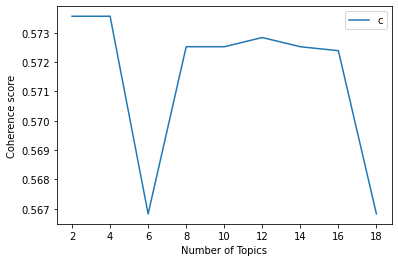

In [16]:
def plot_graph(doc_clean,start, stop, step,sentiment):
    dictionary, doc_term_matrix = prepare_corpus(doc_clean,sentiment)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    for m, cv in zip(x, coherence_values):
        print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

start,stop,step = 2, 20, 2
plot_graph(df['clean_tokens_list'], start, stop, step, 'Positive')

In [17]:
%%time
# Positive sentiment model
pos_model=create_gensim_lsa_model(positive_df['clean_tokens_list'],number_of_topics,words,'Positive')
# Negative sentiment model
neg_model=create_gensim_lsa_model(negative_df['clean_tokens_list'],number_of_topics,words,'Negative')
# Neutral sentiment model
neu_model=create_gensim_lsa_model(neutral_df['clean_tokens_list'],number_of_topics,words,'Neutral')

[(0, '0.875*"game" + 0.274*"play" + 0.167*"good" + 0.126*"like" + 0.106*"fun" + 0.100*"great" + 0.083*"time" + 0.067*"buy" + 0.056*"love" + 0.056*"hour"'), (1, '0.891*"play" + -0.359*"game" + 0.141*"friend" + 0.124*"fun" + 0.120*"good" + 0.072*"time" + 0.063*"hour" + 0.033*"get" + 0.029*"dota" + 0.028*"want"'), (2, '0.965*"good" + -0.160*"play" + -0.114*"game" + -0.076*"fun" + 0.066*"story" + -0.053*"great" + -0.045*"like" + 0.044*"graphic" + -0.038*"hour" + -0.034*"love"'), (3, '0.859*"like" + -0.214*"game" + 0.192*"fun" + -0.154*"play" + 0.112*"feel" + 0.089*"minecraft" + 0.086*"thing" + 0.077*"lot" + 0.072*"new" + 0.065*"weapon"'), (4, '0.811*"great" + 0.341*"fun" + -0.260*"like" + 0.147*"story" + -0.138*"game" + -0.128*"play" + 0.103*"friend" + 0.088*"gameplay" + 0.080*"lot" + 0.075*"time"'), (5, '0.693*"fun" + -0.357*"story" + -0.306*"great" + 0.198*"friend" + -0.164*"like" + -0.163*"bioshock" + -0.140*"play" + -0.134*"character" + -0.099*"amazing" + -0.098*"fallout"'), (6, '0.771

In [18]:
!pip install wordcloud
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

def visual_topics(model):
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  
    
    cloud = WordCloud(stopwords=stop_words,
                      background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)

    topics = model.show_topics(formatted=False)

    fig, axes = plt.subplots(4, 2, figsize=(8,8), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        cloud.fit_words(dict(model.show_topic(i, 200)))
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')


    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


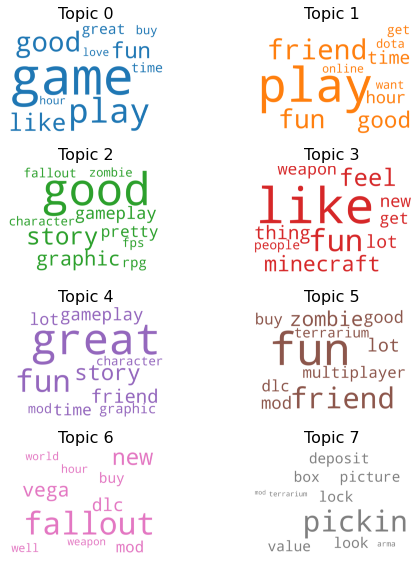

In [19]:
visual_topics(pos_model)

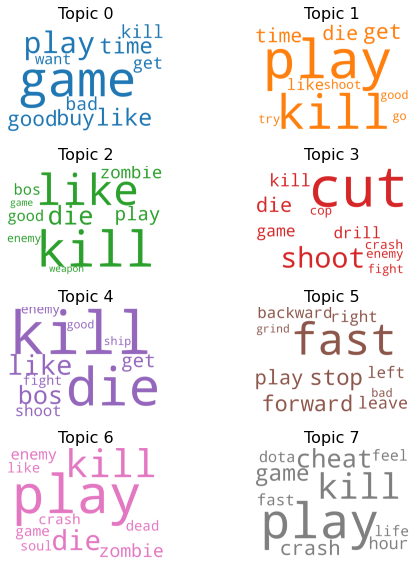

In [20]:
visual_topics(neg_model)

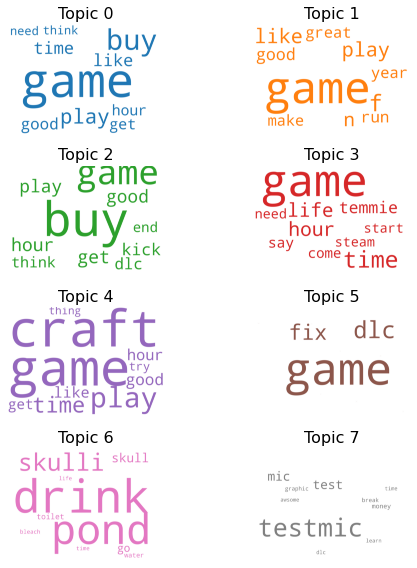

In [21]:
visual_topics(neu_model)

## Gensim LDA

In [22]:
def lda_gen(clean_data):
    # Making dictionary
    dictionary = corpora.Dictionary(clean_data)
    # Remove extremes
    dictionary.filter_extremes(no_below=2, no_above=0.5)
    # Making corpus
    corpus = [dictionary.doc2bow(text) for text in clean_data]
    # Making model
    num_topics = 8
    chunksize = 2000
    passes = 20
    iterations = 400
    eval_every = None

    temp = dictionary[0]
    id2word = dictionary.id2token

    model = LdaModel(
        corpus=corpus,
        id2word=id2word,
        chunksize=chunksize,
        alpha='auto',
        eta='auto',
        iterations=iterations,
        num_topics=num_topics,
        passes=passes,
        eval_every=eval_every
    )
  
    return model

In [23]:
def print_topics(sentiment):
    if sentiment == 'Positive':
        dictionary = corpora.Dictionary(positive_df['clean_tokens_list'])
        corpus = [dictionary.doc2bow(text) for text in positive_df['clean_tokens_list']]
        top_topics = lda_gen(positive_df['clean_tokens_list']).top_topics(corpus)
    elif sentiment == 'Negative':
        dictionary = corpora.Dictionary(negative_df['clean_tokens_list'])
        corpus = [dictionary.doc2bow(text) for text in negative_df['clean_tokens_list']]
        top_topics = lda_gen(negative_df['clean_tokens_list']).top_topics(corpus)
    elif sentiment == 'Neutral':
        dictionary = corpora.Dictionary(neutral_df['clean_tokens_list'])
        corpus = [dictionary.doc2bow(text) for text in neutral_df['clean_tokens_list']]
        top_topics = lda_gen(neutral_df['clean_tokens_list']).top_topics(corpus)
    pprint(top_topics)

In [24]:
print("Printing positive topcis")
print("==========================")
print_topics('Positive')
print("Printing negative topcis")
print("==========================")
print_topics('Negative')
print("Printing neutral topcis")
print("==========================")
print_topics('Neutral')

Printing positive topcis
[([(0.17970935, 'play'),
   (0.07327519, 'fun'),
   (0.066525914, 'great'),
   (0.0538792, 'time'),
   (0.0319903, 'hour'),
   (0.031104915, 'get'),
   (0.027616855, 'lot'),
   (0.02751784, 'recommend'),
   (0.027348343, 'friend'),
   (0.019084392, 'pretty'),
   (0.018049436, 'worth'),
   (0.017408485, 'money'),
   (0.01593535, 'spend'),
   (0.015694449, 'enjoy'),
   (0.014338031, 'bit'),
   (0.0136451945, 'long'),
   (0.012752518, 'cool'),
   (0.01148009, 'hard'),
   (0.011347016, 'stuff'),
   (0.011280479, 'little')],
  -7.694406449185647),
 ([(0.049777027, 'amazing'),
   (0.043696303, 'story'),
   (0.03648858, 'character'),
   (0.03557863, 'gameplay'),
   (0.03332869, 'graphic'),
   (0.019898998, 'mission'),
   (0.016568512, 'experience'),
   (0.01605502, 'rpg'),
   (0.015160357, 'different'),
   (0.013745547, 'combat'),
   (0.013390343, 'level'),
   (0.012361871, 'world'),
   (0.011842251, 'overall'),
   (0.011628584, 'action'),
   (0.01143007, 'unique'),
 

[([(0.028847463, 'time'),
   (0.028068101, 'hour'),
   (0.026931375, 'play'),
   (0.026351599, 'get'),
   (0.018614663, 'like'),
   (0.015569586, 'good'),
   (0.015360632, 'think'),
   (0.014151581, 'try'),
   (0.013688294, 'thing'),
   (0.013613255, 'go'),
   (0.012429337, 'year'),
   (0.012139538, 'feel'),
   (0.012088707, 'come'),
   (0.011830598, 'lot'),
   (0.010480829, 'spend'),
   (0.010168843, 'awsome'),
   (0.009762941, 'start'),
   (0.009515674, 'look'),
   (0.008820434, 'day'),
   (0.008810642, 'story')],
  -12.948216019832886),
 ([(0.36197966, 'game'),
   (0.05968766, 'buy'),
   (0.03371808, 'need'),
   (0.019482246, 'say'),
   (0.01855196, 'grind'),
   (0.01830046, 'minecraft'),
   (0.013018536, 'money'),
   (0.012413489, 'dog'),
   (0.011777986, 'ing'),
   (0.011591991, 'p'),
   (0.010807243, 'run'),
   (0.010036161, 'steam'),
   (0.009494972, 'u'),
   (0.008518395, 'undertale'),
   (0.0072839814, 'gun'),
   (0.0066095185, 'add'),
   (0.006347457, 'addict'),
   (0.0054561

In [25]:
!pip install pyLDAvis
import pickle
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

def lda_vis(model,clean_data):
    if clean_data =='Positive':
        clean_data = positive_df['clean_tokens_list']
        dictionary = corpora.Dictionary(clean_data)
        # Remove extremes
        dictionary.filter_extremes(no_below=2, no_above=0.5)
        # Making corpus
        corpus = [dictionary.doc2bow(text) for text in clean_data]
        lda_visualization = gensimvis.prepare(model,corpus,dictionary, sort_topics=False)
        pyLDAvis.save_html(lda_visualization, 'LDA visualizations_positive.html')
    elif clean_data =='Negative':
        clean_data = negative_df['clean_tokens_list']
        dictionary = corpora.Dictionary(clean_data)
        # Remove extremes
        dictionary.filter_extremes(no_below=2, no_above=0.5)
        # Making corpus
        corpus = [dictionary.doc2bow(text) for text in clean_data]
        lda_visualization = gensimvis.prepare(model,corpus,dictionary, sort_topics=False)
        pyLDAvis.save_html(lda_visualization, 'LDA visualizations_negative.html')
    elif clean_data =='Neutral':
        clean_data = neutral_df['clean_tokens_list']
        dictionary = corpora.Dictionary(clean_data)
        # Remove extremes
        dictionary.filter_extremes(no_below=2, no_above=0.5)
        # Making corpus
        corpus = [dictionary.doc2bow(text) for text in clean_data]
        lda_visualization = gensimvis.prepare(model,corpus,dictionary, sort_topics=False)
        pyLDAvis.save_html(lda_visualization, 'LDA visualizations_neutral.html')


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [26]:
lda_vis(lda_gen(positive_df['clean_tokens_list']),'Positive')
lda_vis(lda_gen(negative_df['clean_tokens_list']),'Negative')
lda_vis(lda_gen(neutral_df['clean_tokens_list']),'Neutral')